## DATASET PREPROCESSING

### Import e variabile init

In [1]:
# STEP EXECUTED IN THE PREPROCESSING
import os
import shutil
from PIL import Image
import cv2
import skimage
import pydicom
import scipy
import numpy as np
import math
from matplotlib import pyplot as plt
from glob import glob

from border_detector import BorderDetector

# dir structure of the preprocessed set
dir_structure = {
    "./Preprocessed_Set/":
    {
        "T1DUAL": 
        {
            "InPhase": 
            {
                "Images": {}, 
                "Masks" : {}
            },
            "OutPhase":
            {
                "Images": {}, 
                "Masks" : {}
            } 
            
        },
        "T2SPIR":
        {
            "Images": {}, 
            "Masks" : {}
        } 
    }
}

### Auxiliar functions

In [20]:
# STEP EXECUTED IN THE PREPROCESSING
"""
Get all possible paths from the directory tree specified
"""
def get_paths(directory_tree):
    def _get_paths(directory_tree):

        paths = ["", ]
        for dir, subdir in directory_tree.items():
            current_path = dir
            ret_paths = _get_paths(subdir)
            for ret_path in ret_paths:
                paths.append(os.path.join(dir, ret_path))
        
        return paths
    
    result = _get_paths(directory_tree)
    result.remove('')    

    return result

# finds a particular directory or file in the directory tree
def find_path(directory_tree, dir_name):
    result = []
    for cur_dir in directory_tree.keys():
        if cur_dir == dir_name:
            result.append(cur_dir)
            
        for found_dir in find_path(directory_tree[cur_dir], dir_name):
            result.append(os.path.join(cur_dir,found_dir))
    
    return result
        

### Directory creation
The directory of the preprocessed set is created as illustrated below or as it is writtend in `dir_structure` variable.  
This is useful for working with one protocol at time, maybe should be modified if all protocols are used at the same time.  
  
Directory structure:  
Preprocessed_set_2    
|-> T1DUAL  
----|-> InPhase  
--------|-> Images  
--------|-> Masks  
----|-> OutPhase  
--------|-> Images  
--------|-> Masks  
|-> T2SPIR  
----|-> Images  
----|-> Masks  

In [21]:
# STEP EXECUTED IN THE PREPROCESSING

#Creating a directory_tree from a real directory tree
def build_directory_tree(path):
    def _build_directory_tree(path):
        cur_dir = dict()
        _, subdirs, _ = os.walk(path).__next__()
        for subdir in subdirs:
            cur_dir[subdir] = _build_directory_tree(os.path.join(path,subdir))

        return cur_dir

    result = dict()
    result[os.path.basename(path)] = _build_directory_tree(path)

    return result

In [22]:
# STEP EXECUTED IN THE PREPROCESSING
# building Preprocessed_Set directory
for path in get_paths(dir_structure):
    os.mkdir(path)

In [23]:
# STEP EXECUTED IN THE PREPROCESSING
# preparing to transfer files to the new directory
chaos_directory_tree = build_directory_tree("./CHAOS_Train_Sets")
chaos_directory_tree["CHAOS_Train_Sets"]["Train_Sets"].pop("CT")
print(get_paths(chaos_directory_tree))

['CHAOS_Train_Sets/', 'CHAOS_Train_Sets/Train_Sets/', 'CHAOS_Train_Sets/Train_Sets/MR/', 'CHAOS_Train_Sets/Train_Sets/MR/1/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/DICOM_anon/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/DICOM_anon/OutPhase/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/Ground/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/DICOM_anon/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/Ground/', 'CHAOS_Train_Sets/Train_Sets/MR/10/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/DICOM_anon/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/DICOM_anon/InPhase/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/DICOM_anon/OutPhase/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/Ground/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T2SPIR/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T2SPIR/DICOM_anon/', 'CHAOS_Train_Sets/Train_Se

### Moving files to the new directory

In [24]:
# STEP EXECUTED IN THE PREPROCESSING
prep_t1dual_path = "./Preprocessed_Set/T1DUAL"
prep_t2spir_path = "./Preprocessed_Set/T2SPIR"
chaos_paths = get_paths(chaos_directory_tree)

for index, path in enumerate(chaos_paths):
    # different directory structure for T1DUAL and T2SPIR, cannot use the same code
    if ( os.path.basename(path[:-1]) == "T1DUAL"):
        inphase_path = chaos_paths[index+2]
        outphase_path = chaos_paths[index+3]
        ground_path = chaos_paths[index+4]

        # copying the images
        for phase_path in [inphase_path, outphase_path]:
            _,_,filenames = os.walk(phase_path).__next__()
            for filename in filenames:
                src_path = os.path.join(phase_path, filename)
                dst_path = os.path.join(prep_t1dual_path, os.path.basename(phase_path[:-1]), "Images",filename)
                shutil.copy(src_path, dst_path)

        # copying the ground truths
        _,_, filenames = os.walk(ground_path).__next__()
        for filename in filenames:
            src_path = os.path.join(ground_path, filename)
            dst_path1 = os.path.join(prep_t1dual_path, "InPhase/Masks",filename)
            dst_path2 = os.path.join(prep_t1dual_path, "OutPhase/Masks",filename)

            shutil.copy(src_path, dst_path1)
            shutil.copy(src_path, dst_path2)

    
    
    elif ( os.path.basename(path[:-1]) == "T2SPIR"):
        images_path = chaos_paths[index+1]
        ground_path = chaos_paths[index+2]
        # copying the images
        _,_,filenames = os.walk(images_path).__next__()
        for filename in filenames:
            src_path = os.path.join(images_path, filename)
            dst_path = os.path.join(prep_t2spir_path, "Images",filename)
            shutil.copy(src_path, dst_path)

        # copying the ground truths
        _,_,filenames = os.walk(ground_path).__next__()
        for filename in filenames:
            src_path = os.path.join(ground_path, filename)
            dst_path = os.path.join(prep_t2spir_path, "Masks",filename)
            shutil.copy(src_path, dst_path)



### From DICOM to PNG

In [25]:
# STEP EXECUTED IN THE PREPROCESSING
images_paths = find_path(dir_structure, "Images")
for images_path in images_paths:
    _,_,image_names = os.walk(images_path).__next__()
    for image_name in image_names:
        image_path = os.path.join(images_path, image_name)
        image = np.array(pydicom.dcmread(image_path).pixel_array)
        Image.fromarray(image).save(image_path.replace(".dcm", ".png"))


In [26]:
# STEP EXECUTED IN THE PREPROCESSING
# removing DICOM images
images_paths = find_path(dir_structure, "Images")
for images_path in images_paths:
    _,_,filenames = os.walk(images_path).__next__()
    for filename in filenames:
        image_path = os.path.join(images_path,filename)
        if filename.endswith(".dcm"):
            os.remove(image_path)



### Image intensity normalization
Images have very different pixel ranges, so normalizing them to range [0-255] is required

The following code shows the difference between max intensities across the dataset

In [4]:
values = []
images_paths = find_path(dir_structure, "Images")
images_path = images_paths[1]
_,_,filenames = os.walk(images_path).__next__()
for filename in filenames:
    image_path = os.path.join(images_path,filename)
    image = np.array(Image.open(image_path))
    cur_max = 0
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y][x] > cur_max: cur_max = image[y][x]
    
    values.append(cur_max)

print(min(values), max(values))

289 1344


In [27]:
# STEP EXECUTED IN THE PREPROCESSING
# image normalization

images_paths = find_path(dir_structure, "Images")
for images_path in images_paths:
    _,_,filenames = os.walk(images_path).__next__()
    for filename in filenames:
        image_path = os.path.join(images_path,filename)
        image = np.array(Image.open(image_path))

        max_val, min_val = max(image.flatten()), min(image.flatten())

        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y][x] = (float(image[y][x] - min_val))/(max_val-min_val) * 255
        
        Image.fromarray(image).save(image_path)
        


### Correcting OutPhase file names
Thei have different names from their respective mask: $LastDigitOutphase = LastDigitMask - 1$.  

In [28]:
# STEP EXECUTED IN THE PREPROCESSING
outphase_path = find_path(dir_structure, "OutPhase")[0]
images_path = os.path.join(outphase_path, "Images")
masks_path = os.path.join(outphase_path, "Masks")

_,_, image_names = os.walk(images_path).__next__()
_,_, mask_names = os.walk(masks_path).__next__()

for i in range(len(image_names)):
    old_image_path = os.path.join(images_path, image_names[i])
    new_image_path = os.path.join(images_path, mask_names[i])
    mask_path = os.path.join(masks_path, mask_names[i])
    
    shutil.move(old_image_path, new_image_path)

### Preparing the mask for sparse (and normal) categorical cross entropy
Value range is set to 0-4, otherwise sparse crossentropy and one hot encoding cannot work properly

In [29]:
# STEP EXECUTED IN THE PREPROCESSING
mapping = dict([(0,0),(63,1),(126,2),(189,3),(252,4)])
uniques = set()
mask_paths = glob("./Preprocessed_Set/*/*/Masks/*png") + glob("./Preprocessed_Set/*/Masks/*png")
for mask_path in mask_paths:
    mask = np.array(Image.open(mask_path))
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            mask[i][j] = mapping[mask[i][j]]
    Image.fromarray(mask).save(mask_path)


### Adding mask class "body
Background and body are pretty different, I prefer to separate them in different classes

In [30]:
# STEP EXECUTED IN THE PREPROCESSING
image_paths = sorted(glob("./Preprocessed_Set/*/*/Images/*png") + glob("./Preprocessed_Set/*/Images/*png"))
mask_paths = sorted(glob("./Preprocessed_Set/*/*/Masks/*png") + glob("./Preprocessed_Set/*/Masks/*png"))

treshold = 10
for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
    if (os.path.basename(image_path) != os.path.basename(mask_path)):
        print("warning: unpaired image-path found:", image_path, mask_path)
        continue

    image = Image.open(image_path)
    img = np.array(Image.open(image_path))
    msk = np.array(Image.open(mask_path))


    new_msk = np.zeros(msk.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (msk[i][j] == 0 and img[i][j] < treshold): new_msk[i][j] = 0
            else: new_msk[i][j] = msk[i][j] + 1

    Image.fromarray(new_msk).save(mask_path)
            

In [31]:
# STEP EXECUTED IN THE PREPROCESSING
# morphological closure for having better mask

#msks = sorted(glob("./Preprocessed_Set/T1DUAL/*/Masks/*.png")) + sorted(glob("./Preprocessed_Set/T2SPIR/Masks/*.png"))
msks = sorted(glob("./Preprocessed_Set/T1DUAL/OutPhase/Masks/*.png"))

counter = 0
for msk_path in msks:
    msk = np.array(Image.open(msk_path))
    body_msk = np.zeros(msk.shape, dtype=msk.dtype)
    for i in range(msk.shape[0]):
        for j in range(msk.shape[1]):
            body_msk[i][j] = 0 if msk[i][j] == 0 else 1

    new_body_msk = cv2.morphologyEx(body_msk, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6)))
    new_msk = np.zeros(msk.shape, dtype=msk.dtype)

    for i in range(msk.shape[0]):
        for j in range(msk.shape[1]):
            new_msk[i][j] = msk[i][j] if msk[i][j] > 1 else new_body_msk[i][j]

    Image.fromarray(new_msk).save(msk_path)


### Adding organ border masks
Borders will have heavier weights

In [32]:
# STEP EXECUTED IN THE PREPROCESSING
# used to detect borders in preprocessing and now for mapping borders to the 6 original classes
border_type = {
    0: [0,0, 6, 7, 8, 9],   # background border with (by index) 0) background, 1) body, 2) liver, 3) right kidney, 4) left kidney, 5) spleen
    1: [0,0,10,11,12,13],   # body border with ... (same)
    2: [14,15,0,16,17,18],  # liver border with ... (same)
    3: [19,20,21,0,22,23],  # right kidney border with ... (same)
    4: [24,25,26,27,0,28],  # left kidney border with ... (same)
    5: [29,30,31,32,33,0]   # spleen border with ... (same)
}

bd = BorderDetector(border_type)

In [33]:
# STEP EXECUTED IN THE PREPROCESSING
mask_paths = glob("./Preprocessed_Set/T1DUAL/*/Masks/*.png") + glob("./Preprocessed_Set/T2SPIR/Masks/*.png")
for mask_path in mask_paths:
    msk = np.array(Image.open(mask_path))
    border_msk = bd.detect_and_amplify(msk, num_iter=2, only_if_0=True)
    for row in range(msk.shape[0]):
        for col in range(msk.shape[1]):
            if border_msk[row][col] > 0:
                msk[row][col] = border_msk[row][col]
    Image.fromarray(msk).save(mask_path)

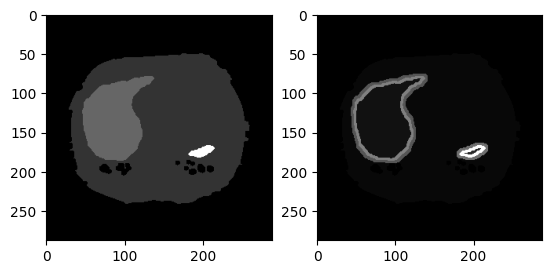

In [4]:
# showing the results
from random import Random
files = glob("./Preprocessed_Set/T1DUAL/OutPhase/Masks/*.png")
rnd = Random()
#rnd.seed(2)
file = files[rnd.randint(1,len(files))]
file2 = file.replace("Set", "Set_no_borders")

old_msk = np.array(Image.open(file2))
plt.subplot(1,2,1)
plt.imshow(old_msk, cmap="gray")
msk = np.array(Image.open(file))
plt.subplot(1,2,2)
plt.imshow(msk, cmap="gray")

## Other stuffs used in the past

<u>Ridimensionamento immagini e maschere</u>
  
Siccome alcune immagini e maschere hanno dimensione diversa da 256x256, le uniformo a tale misura.  
Se ridimensiono le immagini (da $288^2$ a $256^2$) in modo non attento, modifico i pixel delle maschere e rischio di portarli dal range di un organo a quello di un altro. Devo evitare questa cosa.  
Possibili soluzioni:
* divido il range 0-255 in classi continue
    * problema: se interpolo tra right kidney e background, tra i 2 "genero" dei pixel del range del liver ma non ha senso
* il ridimensionamento dell'immagine avviene con ordine di interpolazione qualsiasi MA quello della maschera con ordine di interpolazione = 0 -> mantengo i valori già esistenti
  
Ho scelto per questo motivo di ridimensionare sia immagine sia maschera con ordine = 0 (costante)  

In [ ]:
images_paths = find_path(dir_structure, "Images")

for images_path in images_paths:
    masks_path = os.path.join(os.path.split(images_path)[0], "Masks")
    
    _,_,image_names = os.walk(images_path).__next__()
    _,_,mask_names = os.walk(masks_path).__next__()

    for index, image_name in enumerate(image_names):
        image_path = os.path.join(images_path, image_name)
        mask_path = os.path.join(masks_path, mask_names[index])

        image = pydicom.dcmread(image_path)
        mask = Image.open(mask_path)

        # reshape di immagine e maschera
        if ( image.pixel_array.shape != (256,256)):
            os.remove(image_path)
            os.remove(mask_path)
            image = np.array(image.pixel_array)
            mask = np.array(mask)
            target_shape = (
                256/image.shape[0],
                256/image.shape[1]
            )
            reshaped_image = scipy.ndimage.zoom(image, target_shape, order=0, mode="nearest")    
            reshaped_mask = scipy.ndimage.zoom(mask, target_shape, order=0, mode="nearest")    
        else:
            reshaped_image = np.array(image.pixel_array)
            reshaped_mask = np.array(mask)
        Image.fromarray(reshaped_image).save(image_path.replace(".dcm", ".png"))
        Image.fromarray(reshaped_mask).save(mask_path)


# IN CHE FILE SALVO L'IMMAGINE? non dcm PERCHè HA UN HEADER => PNG (semplicemente ho salvato l'array in un file)

In [ ]:
# qui se voglio fare reshape solo delle maschere

masks_paths = find_path(dir_structure, "Masks")
for masks_path in masks_paths:

    _,_,mask_names = os.walk(masks_path).__next__()
    for index, mask_name in enumerate(mask_names):
        mask_path = os.path.join(masks_path, mask_names[index])

        mask = np.array(Image.open(mask_path))

        # reshape di immagine e maschera
        if ( mask.shape != (256,256)):
            os.remove(mask_path)
            target_shape = (
                256/mask.shape[0],
                256/mask.shape[1]
            )
            reshaped_mask = scipy.ndimage.zoom(mask, target_shape, order=3, mode="nearest")    

            Image.fromarray(reshaped_mask).save(mask_path)